# Homogeneous Groups Demo

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from binary_performance_evaluator import BinaryPerformanceEvaluator

# --------------------------------------------------
# 1. CONFIGURAÇÕES
# --------------------------------------------------
FILE_PATH = "../../datasets/lending_club/accepted_2007_to_2018Q4.csv"
NROWS     = 1_000
TARGET_RAW = "loan_status"          # coluna original
TARGET     = "target"               # nome final binário

# --------------------------------------------------
# 2. LEITURA E CONVERSÃO DE TIPOS MISTOS
# --------------------------------------------------
def read_and_clean_csv_mixed_types(path, nrows=None, verbose=True):
    df = pd.read_csv(path, low_memory=False, nrows=nrows)

    # identificar colunas com tipos mistos
    for col in df.columns:
        types = df[col].dropna().map(type).value_counts()
        if len(types) > 1 and verbose:
            print(f"[!] '{col}' com múltiplos tipos: {dict(types)}")

        # tentativa de conversão automática p/ numérico
        if len(types) > 1:
            try:
                df[col] = pd.to_numeric(df[col], errors="coerce")
            except Exception:
                df[col] = df[col].astype(str)

    return df

df = read_and_clean_csv_mixed_types(FILE_PATH, nrows=NROWS)

# drop de colunas não usadas (caso existam)
df.drop(columns=[c for c in ["member_id"] if c in df.columns], inplace=True)

# --------------------------------------------------
# 3. TARGET BINÁRIO
# --------------------------------------------------
bad_status = ["Charged Off", "Default", "Late (31-120 days)"]
df[TARGET] = df[TARGET_RAW].isin(bad_status).astype(int)

# --------------------------------------------------
# 4. DATA E ID
# --------------------------------------------------
df["date"] = pd.to_datetime(df["issue_d"], format="%b-%Y", errors="coerce")
df.drop(columns=["issue_d", TARGET_RAW], inplace=True)

df.reset_index(drop=False, inplace=True)   # index ➜ nova coluna

# --------------------------------------------------
# 5. FEATURES NUMÉRICAS + IMPUTAÇÃO
# --------------------------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(["id", TARGET])
na_threshold = 0.30
valid_cols = numeric_cols[df[numeric_cols].isna().mean() < na_threshold].tolist()
valid_cols.remove('index')

df[valid_cols] = df[valid_cols].fillna(df[valid_cols].median())

# --------------------------------------------------
# 6. DATAFRAME FINAL
# --------------------------------------------------
df_model = df[["id", "date", TARGET] + valid_cols].dropna().copy()

IndentationError: unexpected indent (binary_performance_evaluator.py, line 341)

In [ ]:
def create_safras_with_perturbations(
    df: pd.DataFrame,
    start_ym: str = "2023-01",          # inclusive
    end_ym: str   = "2023-06",          # inclusive
    target_col: str = "target",
    id_col: str = "id",
    noise_level: float = 0.05,          # 5 % do desvio-padrão
    random_state: int = 42,
    add_date_col: bool = True,
    date_col_name: str = "ref_date"
) -> pd.DataFrame:
    """
    Gera um dataset concatenado com múltiplas 'safras' mensais.
    Cada safra é uma cópia da anterior com perturbação gaussiana
    (ruído aditivo proporcional ao desvio-padrão da feature).

    Parâmetros
    ----------
    df : DataFrame já preparado (ex.: df_model)
    start_ym, end_ym : 'YYYY-MM' de início e fim inclusive
    target_col : nome da coluna binária de target (não perturbada)
    id_col     : identificador único mantido entre safras
    noise_level: fração do desvio-padrão adicionada como ruído (σ_ruído = noise_level * σ_feature)
    random_state : semente para reprodutibilidade
    add_date_col : se True, cria coluna de timestamp no 1º dia do mês
    date_col_name: nome desta coluna de data gerada
    """
    rng = np.random.default_rng(random_state)

    # --- 1. Pré-processamento ----------------------------------------------
    df_base = df.copy(deep=True)
    # Elimina quaisquer colunas de datas já existentes
    date_like = df_base.select_dtypes(include=["datetime", "datetimetz"]).columns
    df_base.drop(columns=date_like, errors="ignore", inplace=True)

    # Identifica colunas numéricas a perturbar (exclui id e target)
    num_cols = df_base.select_dtypes(include=[np.number]).columns.difference([id_col, target_col])

    # Constrói sequência de Year-Month entre start e end (inclusive)
    periods = pd.period_range(start=start_ym, end=end_ym, freq="M")

    # --- 2. Geração das safras ---------------------------------------------
    all_batches = []
    prev_batch = df_base

    for idx, period in enumerate(periods):
        batch = prev_batch.copy(deep=True)

        # Atualiza coluna de safra
        batch["safra"] = int(period.strftime("%Y%m"))

        # Gera coluna de data opcional
        if add_date_col:
            batch[date_col_name] = period.to_timestamp("D")  # 1º dia do mês

        # Aplica ruído a partir da 2ª safra
        if idx > 0:
            for col in num_cols:
                std = prev_batch[col].std(ddof=0)
                noise = rng.normal(loc=0.0, scale=noise_level * std, size=len(batch))
                batch[col] = prev_batch[col] + noise

        all_batches.append(batch)
        prev_batch = batch  # referência para próxima perturbação

    # --- 3. Concatena e devolve --------------------------------------------
    df_safras = pd.concat(all_batches, ignore_index=True)
    return df_safras


In [ ]:
# df_model é o DataFrame que você produziu acima
df_model = create_safras_with_perturbations(
    df_model,
    start_ym="2023-01",
    end_ym="2024-12",
    noise_level=0.05,        # 5 % do desvio-padrão
    random_state=123
)

display(df_model.groupby("safra").size())

safra
202301    1000
202302    1000
202303    1000
202304    1000
202305    1000
202306    1000
202307    1000
202308    1000
202309    1000
202310    1000
202311    1000
202312    1000
202401    1000
202402    1000
202403    1000
202404    1000
202405    1000
202406    1000
202407    1000
202408    1000
202409    1000
202410    1000
202411    1000
202412    1000
dtype: int64

In [ ]:
# --------------------------------------------------
# 7. SPLIT TREINO / TESTE
# --------------------------------------------------
train_idx, test_idx = train_test_split(
    df_model.index,
    test_size=0.30,
    stratify=df_model[TARGET],
    random_state=42,
)

df_train = df_model.loc[train_idx].copy()
df_test  = df_model.loc[test_idx].copy()

X_train, y_train = df_train[valid_cols], df_train[TARGET]
X_test , y_test  = df_test[valid_cols] , df_test[TARGET]


In [ ]:
# --------------------------------------------------
# 8. MODELOS COM PARÂMETROS APRIMORADOS
# --------------------------------------------------
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=2000,
        solver='lbfgs',       # bom para datasets médios
        class_weight='balanced',  # trata desbalanceamento
        C=1.0                 # regularização inversa (quanto menor, mais regularizado)
    ),
    
    "DecisionTree": DecisionTreeClassifier(
        max_depth=6,          # evita overfitting
        min_samples_leaf=50,  # tamanho mínimo das folhas
        class_weight='balanced',
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=300,     
        learning_rate=0.05,   
        max_depth=4,          
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1.0,     # pode ser ajustado com base no desbalanceamento
        #use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        num_leaves=15,            # normalmente ≈ 2^max_depth
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )
}

In [ ]:
# --------------------------------------------------
# 9. LOOP DE TREINO + AVALIAÇÃO COM BinaryPerformanceEvaluator
# --------------------------------------------------
results = {}
for name, model in models.items():
    print(f"\n🔹  Treinando {name}")
    model.fit(X_train, y_train)

    evaluator = BinaryPerformanceEvaluator(
        model=model,
        df_train=df_train,
        df_test=df_test,
        target_col=TARGET,
        id_cols=["id"],
        date_col="date",
        homogeneous_group="auto",
    )

    metrics = evaluator.compute_metrics()
    results[name] = metrics

    radar = evaluator.plot_group_radar()
    radar.update_layout(title=f"Radar – {name}")
    radar.show()

# (opcional) métricas comparativas
#all_metrics = pd.concat(results, names=["model"])
#display(all_metrics)


🔹  Treinando LogisticRegression


c:\Users\JM\AppData\Local\anaconda3\envs\ENV_STONE\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




🔹  Treinando DecisionTree



🔹  Treinando XGBoost



🔹  Treinando LightGBM


In [ ]:
results = {}
for name, model in models.items():
    print(f"\n🚀 Treinando modelo: {name}")
    model.fit(X_train, y_train)

    evaluator = BinaryPerformanceEvaluator(
        model=model,
        df_train=df_train,
        df_test=df_test,
        target_col="target",
        id_cols=["id"],
        date_col="ref_date",
        homogeneous_group="auto",  # usa Optimal Binning
    )
    break

    print(f"📊 Avaliando modelo: {name}")
    metrics_df = evaluator.compute_metrics()
    results[name] = metrics_df

    radar_fig = evaluator.plot_group_radar()
    radar_fig.update_layout(title=f"Radar – {name}")
    radar_fig.show()

# Opcional: juntar todas as métricas em um DataFrame
#df_results = pd.concat(results, names=["modelo"])
#display(df_results)


🚀 Treinando modelo: LogisticRegression


c:\Users\JM\AppData\Local\anaconda3\envs\ENV_STONE\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
metrics = evaluator.compute_metrics()
metrics

c:\Users\JM\Documents\0_CienciaDados\1_Frameworks\RiskPilot\examples\binary_performance_evaluator.py:180: UserWarning:

compute_metrics() has not been called; metrics may be missing.



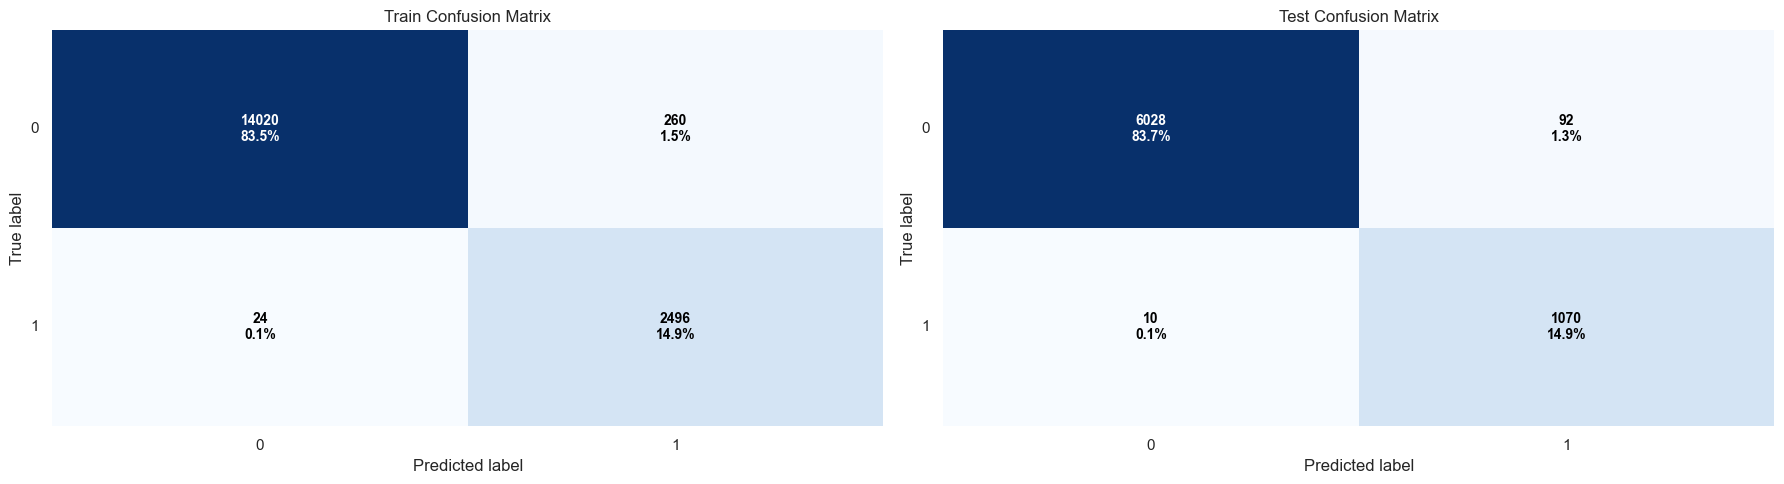

In [ ]:
# Matriz de confusão
evaluator.plot_confusion(save=True)

In [ ]:
# Curva de calibração
evaluator.plot_calibration()

In [ ]:
# Taxa de eventos por grupo
evaluator.plot_event_rate()

In [ ]:
# PSI por variável
evaluator.plot_psi()

c:\Users\JM\Documents\0_CienciaDados\1_Frameworks\RiskPilot\examples\binary_performance_evaluator.py:338: RuntimeWarning:

divide by zero encountered in log

c:\Users\JM\Documents\0_CienciaDados\1_Frameworks\RiskPilot\examples\binary_performance_evaluator.py:338: RuntimeWarning:

invalid value encountered in divide



In [42]:
# Evolução do KS
evaluator.plot_ks()